In [2]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import jax
import pickle as pkl
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np 
import os
import numpy as np
import pickle as pkl
import jax.numpy as jnp
from tqdm import tqdm
from tqdm import tqdm
import flax.linen as nn
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
from jax.tree_util import tree_map,tree_flatten,tree_flatten_with_path,keystr,tree_map_with_path
import matplotlib.pyplot as plt
from jax.numpy.linalg import matrix_norm,vector_norm
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

from main_optlc import get_layer_cushion,get_interlayer_cushion

def plot_states(*paths,plot_lc = False):

    builder = tfds.builder("cifar10",data_dir="./datasets")
    builder.download_and_prepare()
    ds_train,ds_test = builder.as_dataset(split=["train", "test"])

    # Transform dataset from dict into tuple
    solve_dict = lambda elem : (elem["image"],elem["label"])
    ds_train,ds_test = ds_train.map(solve_dict),ds_test.map(solve_dict)

    # Cast image dtype to float32
    cast = lambda img,lbl : (tf.cast(img,tf.dtypes.float32),lbl)
    ds_train,ds_test = ds_train.map(cast),ds_test.map(cast)

    # Normalize images with precalculated mean and std
    mean = tf.convert_to_tensor([0.32768, 0.32768, 0.32768])[None,None,:]
    std = tf.convert_to_tensor([0.27755222, 0.26925606, 0.2683012 ])[None,None,:]
    normalize = lambda img,lbl : ((img/255-mean)/std,lbl)

    # Prepare a number of "settings.num_parallel_exps" independent datasets for training
    ds_train,ds_test = ds_train.map(normalize),ds_test.map(normalize)

    ds_train_eval = ds_train.shuffle(25000).batch(1000).prefetch(64)

    fig,axs = plt.subplots(ncols=max(len(paths),2),nrows=4,sharey = "row")
    fig.set_size_inches(len(paths)*4,12)
    
    for ax,path in enumerate(paths):
        x = []
        y = {2 : {"Dense_0" : [],"Dense_1" : [],"Dense_2" : []}, 
             "fro" : {"Dense_0" : [],"Dense_1" : [],"Dense_2" : [], }, 
             "lc" : {"1" : [], "2" : [], "3" : []}, 
             "ilc" : {"11" : [], "12" : [], "13" : [], "22" : [],"23" : [], "33" : []}}
        for param in tqdm(os.listdir(path)):
            with open(os.path.join(path,param),"rb") as f:
                params = pkl.load(f)

                if "DenseSVD_0" in params["params"].keys():
                    cast_params = {"params" : {"Dense_0" : None,
                                               "Dense_1" : None,
                                               "Dense_2" : None}}
                    @jax.jit
                    @partial(jax.vmap,in_axes=0)
                    def cast_wb(d):
                        svd = jnp.sort(jnp.abs(d["svd"]),descending=True)
                        u,_,vt = jnp.linalg.svd(d["kernel"],full_matrices=False)
                        return {"kernel" : u @ jnp.diag(svd) @ vt,"bias" : d["bias"]}
                        
                    cast_params["params"]["Dense_0"] = cast_wb(params["params"]["DenseSVD_0"])
                    cast_params["params"]["Dense_1"] = cast_wb(params["params"]["DenseSVD_1"])
                    cast_params["params"]["Dense_2"] = cast_wb(params["params"]["DenseSVD_2"])

                    params = cast_params
                    
                x.append(int(param[:-4]))
                for ord in [2,"fro"]:
                    for dense in ["Dense_0","Dense_1","Dense_2"]:
                        y[ord][dense].append(jax.vmap(lambda w : jnp.linalg.matrix_norm(w,ord=ord),in_axes=0)(params["params"][dense]["kernel"])[0])
                if plot_lc:
                    aggregator = []
                    for img,_ in ds_train_eval:
                        ilc11,ilc12,ilc13,ilc22,ilc23,ilc33 = jax.jit(jax.vmap(get_interlayer_cushion,in_axes=(0,None)))(params,jnp.asarray(img))
                        lc1,lc2,lc3 = jax.jit(jax.vmap(get_layer_cushion,in_axes=(0,None)))(params,jnp.asarray(img))
                        aggregator.append((lc1,lc2,lc3,ilc11,ilc12,ilc13,ilc22,ilc23,ilc33))

                    lc1 = jnp.min(jnp.stack([e[0] for e in aggregator]))
                    lc2 = jnp.min(jnp.stack([e[1] for e in aggregator]))
                    lc3 = jnp.min(jnp.stack([e[2] for e in aggregator]))
                    ilc11 = jnp.min(jnp.stack([e[3] for e in aggregator]))
                    ilc12 = jnp.min(jnp.stack([e[4] for e in aggregator]))
                    ilc13 = jnp.min(jnp.stack([e[5] for e in aggregator]))
                    ilc22 = jnp.min(jnp.stack([e[6] for e in aggregator]))
                    ilc23 = jnp.min(jnp.stack([e[7] for e in aggregator]))
                    ilc33 = jnp.min(jnp.stack([e[8] for e in aggregator]))

                    y["lc"]["1"].append(lc1)
                    y["lc"]["2"].append(lc2)
                    y["lc"]["3"].append(lc3)
                    y["ilc"]["11"].append(ilc11)
                    y["ilc"]["12"].append(ilc12)
                    y["ilc"]["13"].append(ilc13)
                    y["ilc"]["22"].append(ilc22)
                    y["ilc"]["23"].append(ilc23)
                    y["ilc"]["33"].append(ilc33)

        arg = np.argsort(x)
        x = np.asarray(x)[arg]
        
        for key,val in y.items():
            for subkey,subval in val.items():
                if y[key][subkey] != []:
                    y[key][subkey] = np.asarray(subval)[arg]

        cap_2 = y[2]["Dense_0"]*y[2]["Dense_1"]*y[2]["Dense_2"]
        cap_Fdiv2 = (y["fro"]["Dense_0"]/y[2]["Dense_0"])+(y["fro"]["Dense_1"]/y[2]["Dense_1"])+(y["fro"]["Dense_2"]/y[2]["Dense_2"])

        axs[0,ax].plot(x,cap_2,label="cap 2")
        axs[0,ax].plot(x,cap_Fdiv2,label="cap F/2")

        if plot_lc:
            axs[1,ax].plot(x,y["lc"]["1"],label="lc1")
            axs[1,ax].plot(x,y["lc"]["2"],label="lc2")
            axs[1,ax].plot(x,y["lc"]["3"],label="lc3")

            axs[2,ax].plot(x,y["ilc"]["11"],label="ilc11")
            axs[2,ax].plot(x,y["ilc"]["12"],label="ilc12")
            axs[2,ax].plot(x,y["ilc"]["13"],label="ilc13")
            axs[2,ax].plot(x,y["ilc"]["22"],label="ilc22")
            axs[2,ax].plot(x,y["ilc"]["23"],label="ilc23")
            axs[2,ax].plot(x,y["ilc"]["33"],label="ilc33")

            axs[3,ax].plot(x,y["lc"]["1"]*(np.min(np.stack([y["ilc"]["11"],y["ilc"]["12"],y["ilc"]["13"]]),axis=0)),label="lcilc1")
            axs[3,ax].plot(x,y["lc"]["2"]*(np.min(np.stack([y["ilc"]["22"],y["ilc"]["23"]]),axis=0)),label="lcilc2")
            axs[3,ax].plot(x,y["lc"]["3"]*y["ilc"]["33"],label="lcilc3")

        axs[0,ax].legend()
        axs[1,ax].legend()
        axs[2,ax].legend()
        axs[3,ax].legend()

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


100%|██████████| 99/99 [01:19<00:00,  1.25it/s]
/tmp/ipykernel_1442690/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,ax].legend()
/tmp/ipykernel_1442690/272244579.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2,ax].legend()
/tmp/ipykernel_1442690/272244579.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3,ax].legend()
100%|██████████| 93/93 [01:36<00:00,  1.04s/it]
/tmp/ipykernel_1442690/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argumen

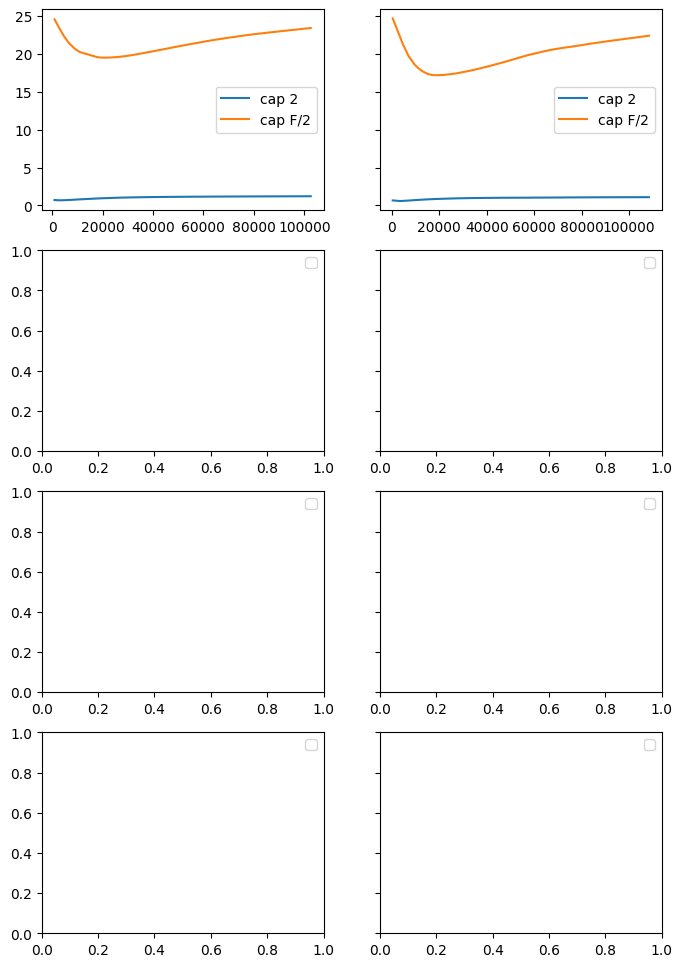

In [7]:
plot_states("./sidequest/DenseSVD/0.0008/run_1/states/dense","./sidequest/DenseSVD/0.00125/run_1/states/dense")

100%|██████████| 20/20 [00:02<00:00,  8.50it/s]
/tmp/ipykernel_1482734/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,ax].legend()
/tmp/ipykernel_1482734/272244579.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2,ax].legend()
/tmp/ipykernel_1482734/272244579.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3,ax].legend()
100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


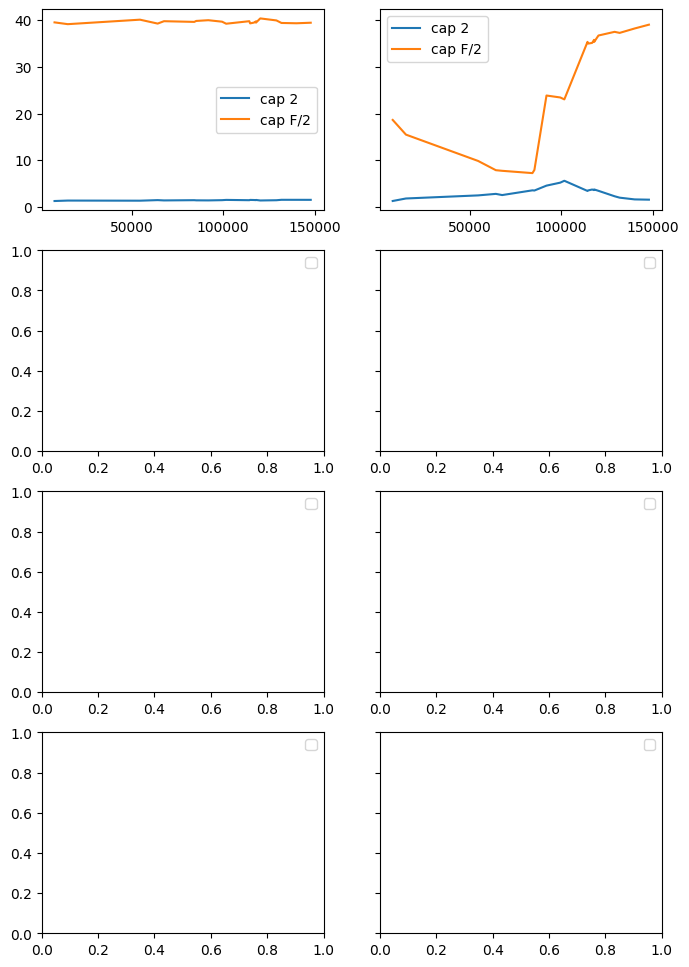

In [20]:
plot_states("./exps_adam/svd_smoothing/1.0_0.95_100/run_1/states/model","./exps_adam/svd_smoothing/25_0.95_100/run_1/states/model")

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:05<00:00,  2.39it/s]
/tmp/ipykernel_1442690/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,ax].legend()
/tmp/ipykernel_1442690/272244579.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2,ax].legend()
/tmp/ipykernel_1442690/272244579.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3,ax].legend()
100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


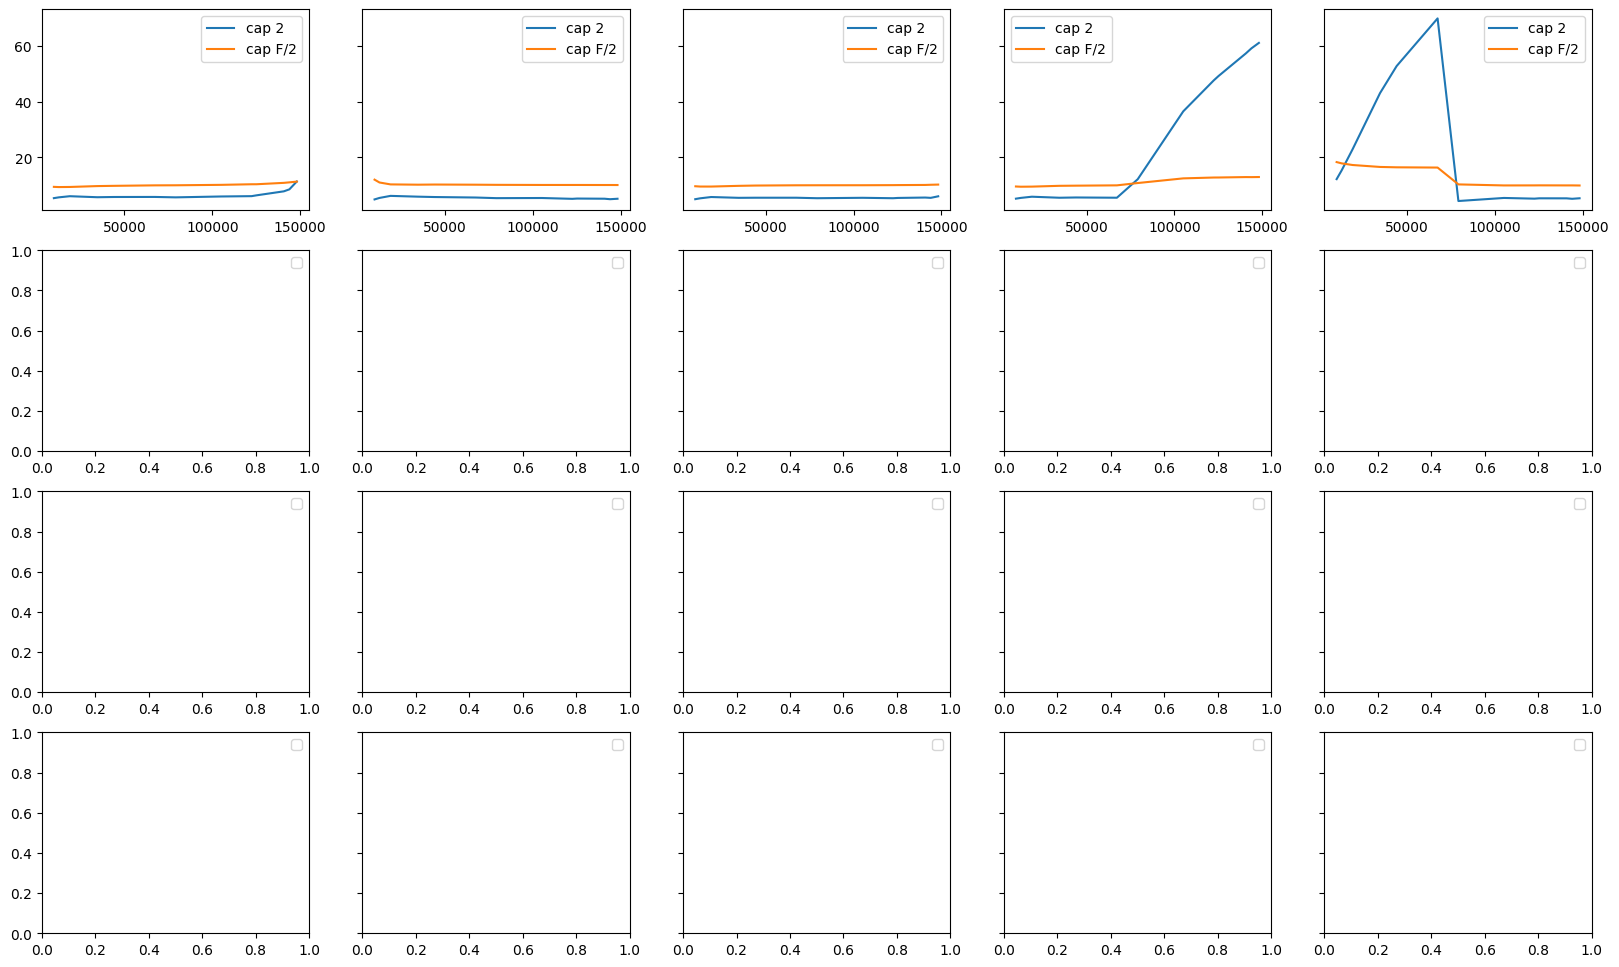

In [9]:
plot_states("./exps_adam/norm_stepscale/0.5_100/run_1/states/model",
            "./exps_adam/norm_stepscale_reverse/0.5_100/run_1/states/model",
            "./exps_adam/norm_layerwise_stepscale/0.5_100/run_1/states/model",
            "./exps_adam/norm_cutoff/0.5_100/run_1/states/model",
            "./exps_adam/norm_cutoff_reverse/0.5_100/run_1/states/model")

100%|██████████| 140/140 [00:35<00:00,  3.94it/s]
/tmp/ipykernel_1442690/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,ax].legend()
/tmp/ipykernel_1442690/272244579.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2,ax].legend()
/tmp/ipykernel_1442690/272244579.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3,ax].legend()


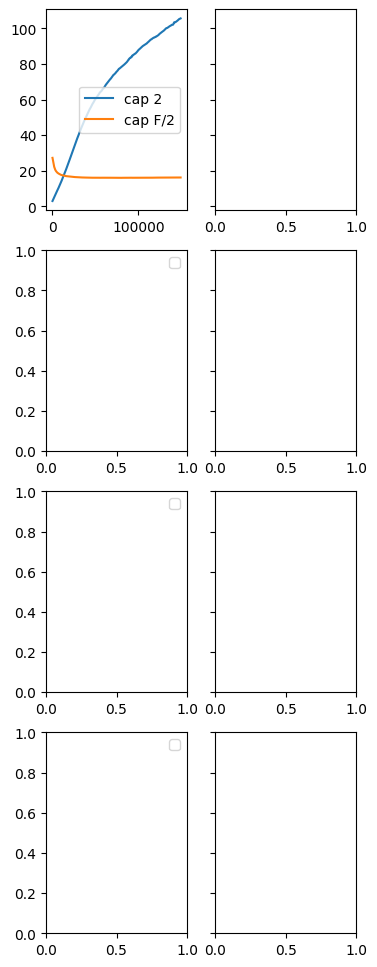

In [10]:
plot_states("./exps_adam/standard/standard0.0001/run_1/states/dense","./exps_adam/standard/standard0.0001/run_1/states/dense")

100%|██████████| 139/139 [00:34<00:00,  4.03it/s]
/tmp/ipykernel_1442690/272244579.py:142: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1,ax].legend()
/tmp/ipykernel_1442690/272244579.py:143: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[2,ax].legend()
/tmp/ipykernel_1442690/272244579.py:144: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[3,ax].legend()
100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


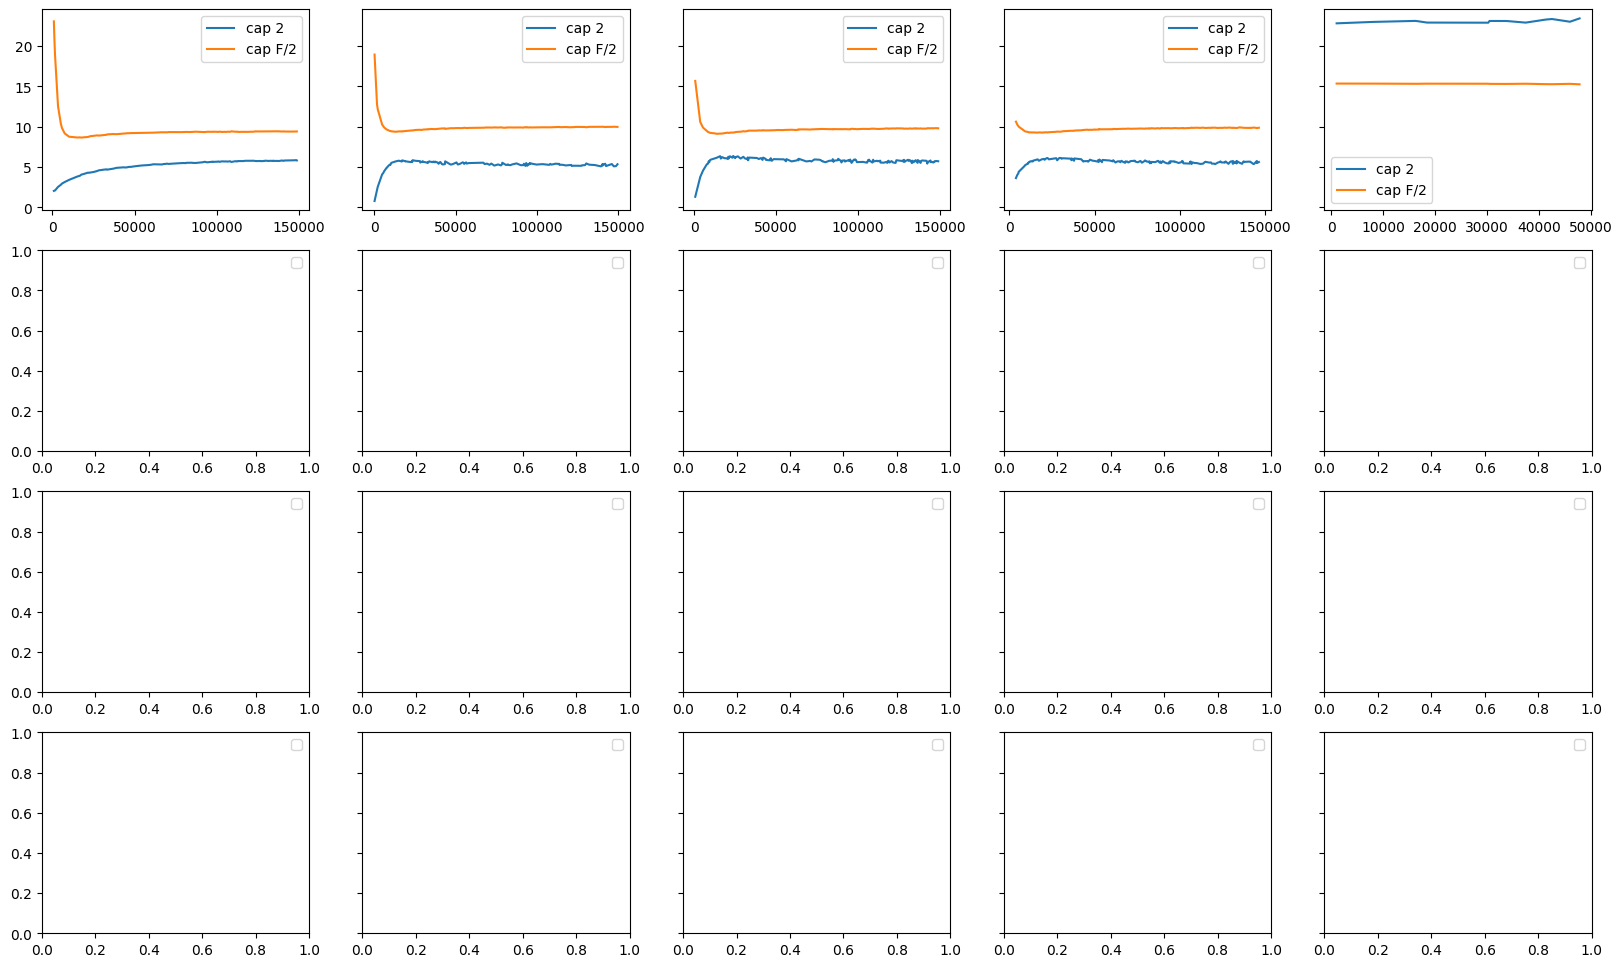

In [6]:

plot_states("./exps_adam/wd/0.01/run_1/states/dense","./exps_adam/norm/0.5_100/run_1/states/dense","./exps_adam/mean_norm/0.5_100/run_1/states/dense","./exps_adam/reverse_mean_norm/0.5_100/run_1/states/dense","./exps_adam/svd_static_exp_fit/1_5_1_100/run_1/states/dense")

In [ ]:
a = jnp.ones(5,32,16)
b = jnp.ones((5,4))
print(jnp.einsum("i,ij -> i",a,b))

[ 0.  4.  8. 12. 16.]
